In [1]:
%pip install --upgrade pip

# Uninstall conflicting packages
%pip uninstall -y langchain-core langchain-openai langchain-experimental langchain-community langchain chromadb beautifulsoup4 python-dotenv PyPDF2 rank_bm25 tiktoken langgraph 

# Install compatible versions of langchain libraries
%pip install langchain-core==0.3.6
%pip install langchain-openai==0.2.1
%pip install langchain-experimental==0.3.2
%pip install langchain-community==0.3.1
%pip install langchain==0.3.1

# Install remaining packages
%pip install chromadb==0.5.11
%pip install beautifulsoup4==4.12.3
%pip install python-dotenv==1.0.1
%pip install PyPDF2==3.0.1 -q --user
%pip install rank_bm25==0.2.2

# new agent-related installs
%pip install tiktoken==0.7.0
%pip install langgraph==0.2.28

Note: you may need to restart the kernel to use updated packages.
Found existing installation: langchain-core 0.3.28
Uninstalling langchain-core-0.3.28:
  Successfully uninstalled langchain-core-0.3.28
Found existing installation: langchain-openai 0.2.1
Uninstalling langchain-openai-0.2.1:
  Successfully uninstalled langchain-openai-0.2.1
Found existing installation: langchain-experimental 0.3.2
Uninstalling langchain-experimental-0.3.2:
  Successfully uninstalled langchain-experimental-0.3.2
Found existing installation: langchain-community 0.3.1
Uninstalling langchain-community-0.3.1:
  Successfully uninstalled langchain-community-0.3.1
Found existing installation: langchain 0.3.1
Uninstalling langchain-0.3.1:
  Successfully uninstalled langchain-0.3.1
Found existing installation: chromadb 0.5.11
Uninstalling chromadb-0.5.11:
  Successfully uninstalled chromadb-0.5.11
Found existing installation: beautifulsoup4 4.12.3
Uninstalling beautifulsoup4-4.12.3:
  Successfully uninstalled beau

In [18]:
import os
os.environ['USER_AGENT'] = 'RAGUserAgent'
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnableParallel
from dotenv import load_dotenv, find_dotenv
from langchain_core.prompts import PromptTemplate
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
load_dotenv()

True

In [19]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)
agent_llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)
embedding_function = OpenAIEmbeddings()
pdf_path = "google-2023-environmental-report.pdf"
collection_name = "google_environmental_report"
str_output_parser = StrOutputParser()
user_query = "What are Google's environmental initiatives?"

In [20]:
pdf_reader = PdfReader(pdf_path)
text = ""
for page in pdf_reader.pages:
    text += page.extract_text()

In [21]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=200
)
splits = character_splitter.split_text(text)

In [22]:
dense_documents = [Document(page_content=text, metadata={"id": str(i), "source": "dense"}) for i, text in enumerate(splits)]
sparse_documents = [Document(page_content=text, metadata={"id": str(i), "source": "sparse"}) for i, text in enumerate(splits)]

In [23]:
chroma_client = chromadb.Client()
vectorstore = Chroma.from_documents(
    documents=dense_documents,
    embedding=embedding_function,
    collection_name=collection_name,
    client=chroma_client
)

In [24]:
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
sparse_retriever = BM25Retriever.from_documents(sparse_documents, k=10)
ensemble_retriever = EnsembleRetriever(retrievers=[dense_retriever, sparse_retriever], weights=[0.5, 0.5], c=0)

In [25]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
!export TAVILY_API_KEY=os.environ['TAVILY_API_KEY']
web_search = TavilySearchResults(max_results=4)
web_search_name = web_search.name

In [26]:
web_search.invoke(user_query)

[{'url': 'https://climateinsider.com/2024/07/04/googles-2024-environmental-report-key-insights-and-opportunities/',
  'content': 'One notable highlight of the report is Google’s achievement of 64% carbon-free energy across all its data centres and offices, with ten grid regions reaching at least 90% carbon-free energy. Google’s environmental report highlights several focal points crucial for addressing the challenges it faces in its climate action journey: Sustainable Transportation: Google is collaborating with the airline industry to develop contrail forecast maps, aimed at reducing the climate impact of contrails. Additionally, Google supports sustainable home heating and cooling systems by providing tools and information that help homeowners make energy-efficient choices. These initiatives highlight Google’s proactive approach to leveraging technology for environmental sustainability, spanning sectors including transportation, energy efficiency, climate adaptation, and smart city d

In [27]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    ensemble_retriever,
    "retrieve_google_environmental_question_answers",
    "Extensive information about Google environmental efforts from 2023.",
)
retriever_tool_name = retriever_tool.name

In [28]:
tools = [web_search, retriever_tool]


In [29]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [31]:
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field  # Updated import
from langgraph.prebuilt import tools_condition

In [32]:
generation_prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer 
    the question. If you don't know the answer, just say 
    that you don't know. Provide a thorough description to 
    fully answer the question, utilizing any relevant 
    information you find.
    
    Question: {question} 
    Context: {context} 
    
    Answer:"""
)

In [33]:
def score_documents(state) -> Literal["generate", "improve"]:

    print("---CHECK RELEVANCE---")

    # Data model - returns a binary score for the relevance check
    class scoring(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(scoring)

    # Prompt
    prompt = PromptTemplate(
        template="""
        You are assessing relevance of a retrieved document to a user question with a binary grade. \n 
        
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """,
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "improve"

In [34]:
def agent(state):
    print("---CALL AGENT---")
    messages = state["messages"]
    llm = agent_llm.bind_tools(tools)
    response = llm.invoke(messages)
    return {"messages": [response]} # Return list, will get added to existing list

In [35]:
def improve(state):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(content=f"""\n 
            Look at the input and try to reason about the underlying semantic intent / meaning. \n 
            Here is the initial question:
            \n ------- \n
            {question} 
            \n ------- \n
            Formulate an improved question: 
            """,
        )
    ]

    # Scoring
    response = llm.invoke(msg)
    return {"messages": [response]}

In [36]:
def generate(state):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Chain
    rag_chain = generation_prompt | llm | str_output_parser

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [37]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)  # retrieval from web and or retriever
workflow.add_node("improve", improve)  # Improving the question for better retrieval
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve (assess agent decision)
workflow.add_conditional_edges("agent", tools_condition, 
    # Translate the condition outputs to nodes in our graph
    {
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called (assess agent decision)
workflow.add_conditional_edges("retrieve", score_documents)
workflow.add_edge("generate", END)
workflow.add_edge("improve", "agent")

# Compile
graph = workflow.compile()

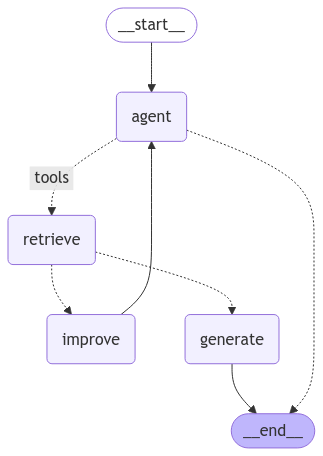

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [39]:
import pprint

inputs = {
    "messages": [
        ("user", user_query),
    ]
}
final_answer = ''
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
        final_answer = value
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_g4xOjCpcV5FQUzFBc8wdJ4Zr', 'function': {'arguments': '{"query":"Google\'s environmental initiatives"}', 'name': 'retrieve_google_environmental_question_answers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549'}, id='run-5bae8093-0f03-43dc-8462-f0eb608860df-0', tool_calls=[{'name': 'retrieve_google_environmental_question_answers', 'args': {'query': "Google's environmental initiatives"}, 'id': 'call_g4xOjCpcV5FQUzFBc8wdJ4Zr', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='The opportunity we have through our products and \nplatforms is reflected in our updated environmental sustainability strategy, which focuses on where we can make t

In [40]:
final_answer['messages'][0]


"Google's environmental initiatives are comprehensive and focus on making a significant positive impact through their products, partnerships, and sustainable business operations. Here are the key aspects of Google's environmental initiatives:\n\n1. **Empowering Individuals**: Google aims to help individuals make more sustainable choices. In 2022, they reached their goal of assisting 1 billion people in making sustainable decisions through features like eco-friendly routing in Google Maps, energy efficiency in Google Nest thermostats, and carbon emissions information in Google Flights. Their future goal is to help reduce 1 gigaton of carbon emissions annually by 2030.\n\n2. **Sustainable Business Operations**: Google is committed to operating sustainably by achieving net-zero carbon emissions, advancing carbon-free energy, and promoting a circular economy. They have invested in renewable energy projects, such as the Golden Hills wind farm in California, and are working on water stewards